In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

import sys
import os
sys.path.append(os.path.abspath('../utils'))
from preprocessing import Preprocessor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
preprocessor = Preprocessor()
zpp4 = preprocessor.zpp4_preprocessing()
spec = preprocessor.spec_preprocessing()

Duplicate rows cleaning: 620it [00:02, 279.37it/s]


In [3]:
# class SuppliersDataset(Dataset):
#     def __init__(self, df):
#         self.df = df
#         self.dataset = df['supplier'].unique()
    
#     def __getitem__(self, index):
#         supplier = self.dataset[index]
        
#         return 
    
#     def __len__(self):
#         return len(self.dataset)

In [4]:
# def preprocess(df):
#     zpp4['day'] = zpp4['day'].map(lambda x: x.day)
#     zpp4['month'] = zpp4['month'].map(lambda x: x.month)
#     # zpp4['weekday'] = zpp4['weekday'].map(lambda x: x.year)
#     zpp4['weekday'] = zpp4['weekday'].map(lambda x: x.weekday())
    
#     zpp4.drop([
#         'date', 'basis', 'spec_date',
#         'contract_price', 'estimated_price',
#         'estimated_price1', 'sum', 'id'], 1)

In [5]:
# zpp4.drop([
#     'date', 'basis', 'spec_date',
#     'contract_price', 'estimated_price',
#     'estimated_price1', 'sum', 'id'], 1)

In [6]:
zpp4.head(2)

,date,supplier,basis,spec_date,contract_price,estimated_price,contract_price1,estimated_price1,quantity,sum,price_change,id
0,2022-07-02,СОЮЗ ООО Ростов,"Юг Руси, АО",2022-06-15,30.0,30.29,30.0,30.32,27.05,820156.0,1.07,"СОЮЗ ООО Ростов_Юг Руси, АО_2022-06-15"
1,2022-07-02,СОЮЗ ООО Ростов,"Юг Руси, АО",2022-06-15,30.0,30.29,30.0,31.02,28.78,892755.6,3.40,"СОЮЗ ООО Ростов_Юг Руси, АО_2022-06-15"


In [7]:
spec.head(2)

,supplier,supplier_status,item,basis,spec_date,delivery_period_end,payment_terms,option,logistics,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted,id
0,50 ЛЕТ ОКТЯБРЯ ООО,СХТП,подсолнечник,"Юг Руси, АО",2022-12-19,2022-12-25,По факту,15.0,0.0,25.5,25.0,25.0,40.0,60.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2022-12-19"
1,50 ЛЕТ ОКТЯБРЯ ООО,СХТП,подсолнечник,"Юг Руси, АО",2023-01-24,2023-02-12,По факту,15.0,0.0,27.5,27.5,27.5,50.0,59.0,1.0,1.0,"50 ЛЕТ ОКТЯБРЯ ООО_Юг Руси, АО_2023-01-24"


In [8]:
# inner join zpp4 и spec, таким образом получаем, только те поставки,
# для которых есть данные о спецификации

data = pd.merge(zpp4, spec, how='inner', on=['id', 'id'], suffixes = ('', '_DROP'))
data = data.drop(['supplier_DROP', 'basis_DROP', 'spec_date_DROP'], 1)
data.head(2)

,date,supplier,basis,spec_date,contract_price,estimated_price,contract_price1,estimated_price1,quantity,sum,price_change,id,supplier_status,item,delivery_period_end,payment_terms,option,logistics,declared_price,consent_price,spec_price,volume_requested,volume_contracted,bids_submitted,bids_contracted
0,2022-07-06,Рязанова А.В. ИП Глава К(Ф)Х,"ЮР Валуйский МЭЗ ф-л, ООО",2022-07-06,25.0,24.78,25.0,24.78,27.44,679963.2,-0.88,Рязанова А.В. ИП Глава К(Ф)Х_ЮР Валуйский МЭЗ ...,Трейдер,подсолнечник,2022-07-09,По факту,10.0,0.0,0.0,25.0,25.0,30.0,30.0,1.0,1.0
1,2022-07-12,Осипов Л.А. ИП Глава К(Ф)Х,"Юг Руси, АО",2022-07-12,25.0,24.68,25.0,24.55,31.43,771606.5,-1.80,"Осипов Л.А. ИП Глава К(Ф)Х_Юг Руси, АО_2022-07-12",СХТП,подсолнечник,2022-07-22,По факту,10.0,0.0,25.0,25.0,25.0,220.0,170.0,1.0,1.0


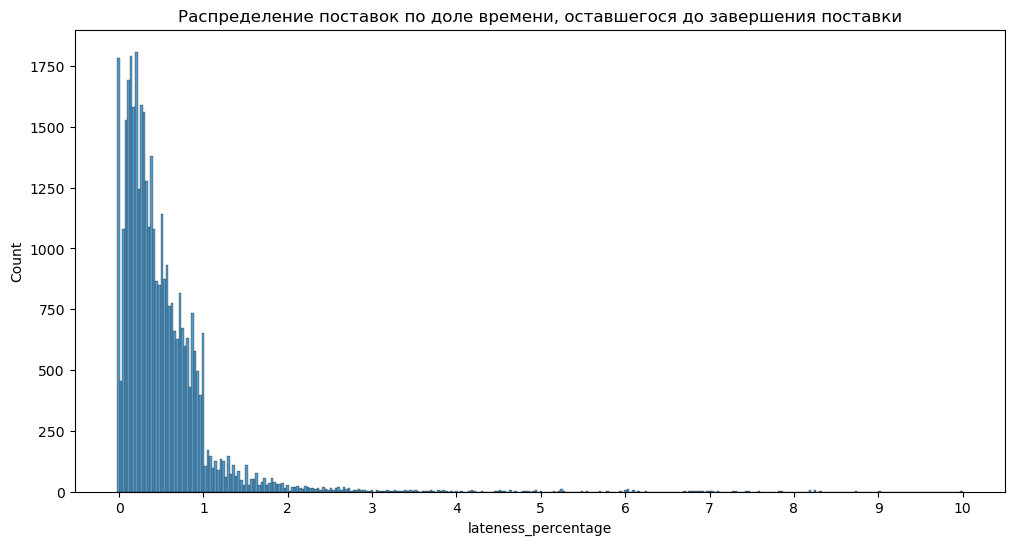

In [9]:
# Распределение поставок по шкале, где 0 - начало спецификации,
# а 1 - конец поставок

data['lateness_percentage'] = list(map(
    lambda x: (x[1]-x[0])/(x[2]-x[0]),
    data[['spec_date', 'date', 'delivery_period_end']].values
))

# Удаление артефактов

# спецификация и конец поставки в тот же день, поэтому получился inf
data = data.drop(data.loc[data['lateness_percentage'] == np.inf].index)
# поставка раньше спецификации
data.loc[data['lateness_percentage'] < 0, 'lateness_percentage'] = 0.

plt.figure(figsize=(12, 6))
g = sns.histplot(data['lateness_percentage']).set(
    title='Распределение поставок по доле времени, оставшегося до завершения поставки',
    xticks = range(11)
)

In [28]:
# Доля уже доставленного товара от всего законтрактованого договору

# data['weight_percentage'] = data.groupby('id')['quantity'].cumsum() / data['volume_contracted']

# Удаление артефактов

# volume_contracted равное 0
data = data.drop(data.loc[data['weight_percentage'] == np.inf].index)

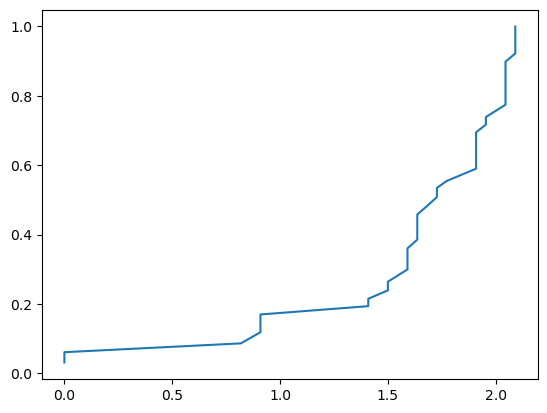

In [36]:
# можно посмотреть динамику поставки товара,
# 1 - товар доставлен в полном объёме

history = data[data['id'] == data['id'].unique()[133]]
plt.plot(history['lateness_percentage'], history['weight_percentage'])

In [39]:
common_x = np.linspace(0, data['lateness_percentage'].max(), num=10000)

In [31]:
data_series = [
    (data[data['lateness_percentage'] == spec_id].values, data[data['id'] == spec_id].values)
    for spec_id in data['id'].unique()
]

In [41]:
# interpolated_series = []
# for series in data_series:
#     time, y = series
#     interpolated_y = np.interp(common_x, time, y, left=np.nan, right=np.nan)
#     interpolated_series.append(interpolated_y)

In [52]:
global_max_x = 5.
step = 0.01

supply_id = data['id'].unique()[133]
common_x = np.linspace(0, data[data['id'] == supply_id]['lateness_percentage'].max(), num=10)
interpolated_y = np.interp(
    common_x,
    data[data['id'] == supply_id]['lateness_percentage'].values,
    data[data['id'] == supply_id]['weight_percentage'].values,
    left=np.nan,
    right=np.nan
)

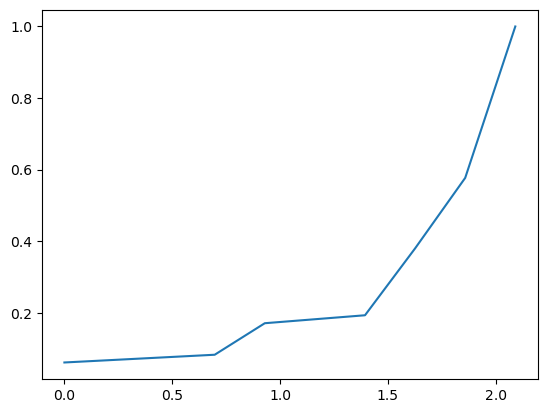

In [53]:
plt.plot(common_x, interpolated)